缺口策略：
缺口一天内不补，说明短期趋势确定了而且比较强。从下一日开始按照跳缺的方向做多/空 两天
连续两次一天内缺口不补，确立中期趋势，认为反向缺口会补，所以遇到反向缺口按照会补的方向来做，直到不补缺口为止，认为趋势消失

改进思路：
1. 短期盘整之后的有效突破
2. 刚开盘容易骗炮
3. 







# 国债期货策略研究

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import datetime
import statsmodels.api as sm
import scipy
from tqdm import tqdm_notebook 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from statsmodels import api as stm 
from statsmodels import tools
from scipy.optimize import minimize
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import prettytable as pt
from numpy import random
import gc 
import psutil
import os
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='retina'
%matplotlib inline

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

## 回测框架

In [19]:
class back_test():
    # 输入的信号应该是时间点，当天仓位的大小
    # 价格应该是所有时间点的价格数据
    #输入数据格式都是dataframe格式
    def __init__(self,position, price,frequency):
        
        self.asset_price = price
        self.asset_price.columns = [0]
        self.position = pd.DataFrame(position.values,index = position.index) 
        self.asset_return = price.pct_change()
        self.asset_return.iloc[0] = 0
        self.frequency = frequency
        
    def calculate_net_value(self):
        self.each_return = pd.DataFrame(self.position.values*self.asset_return.values, index = self.position.index)
        self.net_value = (self.each_return+1).cumprod()
    
    def drawdown(self):
        self.withdraw = (self.net_value-self.net_value.cummax())/self.net_value.cummax()
        self.max_withdraw = (self.withdraw).min().values[0]
    
    def win_and_odd(self):
        record = pd.DataFrame()#用来记录每一次操作
        count_position = self.position.copy()
        count_position['number'] = list(range(len(self.position)))
        i = 0
        open_position = self.position[(self.position.abs()>0).values]#所有仓位大于0的位置 
        while i < len(open_position)-1 :
            this_index = open_position.index[i]
            index_number =  int(count_position.loc[this_index].iloc[1])
            last_index =self.position.index[index_number-1]
            next_index = self.position.index[index_number+1]
                                
            if i == 0:#第一个位置记一次开仓点
                #print(open_number)
                open_time = last_index
                direction = open_position.iloc[i].values[0]/abs(open_position.iloc[i].values[0])
                
                # 如果前后两次开仓的时间点中仓位不同，则进行了开仓
            if (i>0) and (self.position.loc[last_index].values[0]!= self.position.loc[this_index].values[0]):
                open_time = last_index
                direction = open_position.iloc[i].values[0]/abs(open_position.iloc[i].values[0])
                                
#                 #如果前后两次开仓的时间点中时间不连续，则进行了开仓
#             if (i>0) and (open_position.index[i-1] != last_index ):
#                 open_number = count_position.loc[open_position.index[i]].iloc[1]-1
#                 open_time = self.position.index[int(open_number)]
#                 direction = open_position.iloc[i].values[0]/abs(open_position.iloc[i].values[0])
                                
            self.debug = open_position
                #如果当下时间点和下次时间点中仓位不同，则进行了平仓
            if  (i<(len(open_position)-1)) and (self.position.loc[next_index].values[0]!= self.position.loc[this_index].values[0]):
                close_time = this_index
                operation_return = (self.asset_price.loc[close_time].values[0]/self.asset_price.loc[open_time].values[0]-1)*direction
                record = record.append([[open_time,close_time,direction,operation_return]])
                                
#                 #如果下次有仓位的时间和真实下次时间不同，则进行了平仓
#             if  (i<(len(open_position)-1)) and (open_position.index[i+1]!=next_index):
#                 close_time = open_position.index[i]
#                 operation_return = (self.asset_price.loc[close_time].values[0]/self.asset_price.loc[open_time].values[0]-1)*direction
#                 record = record.append([[open_time,close_time,direction,operation_return]])    
                                
                #最后一个有仓位的时间自动清仓
            if (i==(len(open_position)-1)):
                close_time = this_index
                operation_return = (self.asset_price.loc[close_time].values[0]/self.asset_price.loc[open_time].values[0]-1)*direction
                record = record.append([[open_time,close_time,direction,operation_return]])
            i = i+1
         
        self.record = record
        self.record.index = list(range(len(record)))
        self.record.columns = ["开仓时间点","平仓时间点","操作方向","单次回报"]
        self.win_rate = len(self.record[(self.record["单次回报"]>0).values])/len(self.record)
        self.odd_rate = -self.record[(self.record["单次回报"]>0).values]["单次回报"].sum()/self.record[(self.record["单次回报"]<0).values]["单次回报"].sum()
        
        self.long_record = self.record[(self.record["操作方向"]>0).values]
        self.short_record = self.record[(self.record["操作方向"]<0).values]
        self.long_win_rate = len(self.long_record[(self.long_record["单次回报"]>0).values])/len(self.long_record)
        self.short_win_rate = len(self.short_record[(self.short_record["单次回报"]>0).values])/len(self.short_record)
        self.long_odd_rate = -self.long_record[(self.long_record["单次回报"]>0).values]["单次回报"].sum()/self.long_record[(self.long_record["单次回报"]<0).values]["单次回报"].sum()
        self.short_odd_rate = -self.short_record[(self.short_record["单次回报"]>0).values]["单次回报"].sum()/self.short_record[(self.short_record["单次回报"]<0).values]["单次回报"].sum()                 

    #计算年化回报、年化波动率和夏普比
    def sharpe_ratio(self,frequency):
        self.annual_return = self.net_value.values[-1,0]**(frequency/len(self.net_value))-1
        self.annual_std = self.each_return.values.std()*np.sqrt(frequency)
        self.sharpe = self.annual_return/self.annual_std
    
    def show_result(self):
        self.calculate_net_value()
        self.sharpe_ratio(250*self.frequency)
        self.drawdown()
        self.win_and_odd()
        tb = pt.PrettyTable()
        tb.field_names = ["   ","回测结果展示"]
        tb.add_row(["年化收益率",self.annual_return.round(4)])
        tb.add_row(["年化波动率",self.annual_std.round(4)])
        tb.add_row(["夏普比",self.sharpe.round(4)])
        tb.add_row(["胜率",round(self.win_rate,4)])
        tb.add_row(["赔率",round(self.odd_rate,4)])
        tb.add_row(["做多胜率",round(self.long_win_rate,4)])
        tb.add_row(["做多赔率",round(self.long_odd_rate,4)])
        tb.add_row(["做空胜率",round(self.short_win_rate,4)])
        tb.add_row(["做空赔率",round(self.short_odd_rate,4)])
        tb.add_row(["最大回撤",self.max_withdraw.round(4)])
        
        tb.add_row(["回测开始时间",str(self.position.index[0])])
        tb.add_row(["回测结束时间",str(self.position.index[-1])])
        
        print(tb)
        
    def result_plot(self):
        cc= new.net_value.copy()
        cc.columns = ["净值"]
        res = pd.concat([cc,future_price],axis=1).dropna()
        res.iloc[:,:2].plot(legend=True,figsize=(15,10),title='曲线')
        self.out = res

## 数据预处理

In [3]:
day_number = 18*3
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]
#print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
def draw_data(raw_data):
    data = raw_data[['close','volume']]#我们只使用收盘价和成交量两个数据
    data.iloc[:,1] = data.iloc[:,1].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data=data[data.index.minute.isin([1,16,31,46])] 
    data['close'] = data['close'].pct_change()
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,1].rolling(day_number).sum()<nn.iloc[:,3].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()
future1.iloc[0,0] = 0
future_return = future1.loc[future1.index[1]:future1[(future1.iloc[:,1]>0).values].index[-1]]
future_return.columns = ['价格变动','成交量']
future_price = future_return.copy()
future_price.iloc[:,0] = (future_price.iloc[:,0]+1).cumprod()
future_price.columns = ['价格','成交量']

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
合约切换时间： 2015-08-14 11:16:00
处理文件T1603.CCFX.xlsx
合约切换时间： 2015-11-24 10:46:00
处理文件T1606.CCFX.xlsx
合约切换时间： 2016-02-18 11:16:00
处理文件T1609.CCFX.xlsx
合约切换时间： 2016-05-10 10:16:00
处理文件T1612.CCFX.xlsx
合约切换时间： 2016-08-11 14:01:00
处理文件T1703.CCFX.xlsx
合约切换时间： 2016-11-10 14:31:00
处理文件T1706.CCFX.xlsx
合约切换时间： 2017-01-25 10:01:00
处理文件T1709.CCFX.xlsx
合约切换时间： 2017-05-11 13:46:00
处理文件T1712.CCFX.xlsx
合约切换时间： 2017-08-10 10:16:00
处理文件T1803.CCFX.xlsx
合约切换时间： 2017-11-13 10:31:00
处理文件T1806.CCFX.xlsx
合约切换时间： 2018-02-12 11:01:00
处理文件T1809.CCFX.xlsx
合约切换时间： 2018-05-21 10:46:00
处理文件T1812.CCFX.xlsx
合约切换时间： 2018-08-16 13:31:00
处理文件T1903.CCFX.xlsx
合约切换时间： 2018-11-19 13:31:00
处理文件T1906.CCFX.xlsx
合约切换时间： 2019-02-21 14:16:00
处理文件T1909.CCFX.xlsx
合约切换时间： 2019-05-22 10:01:00
处理文件T1912.CCFX.xlsx
合约切换时间： 2019-08-15 13:31:00
处理文件T2003.CCFX.xlsx
合约切换时间： 2019-11-20 13:01:00
处理文件T2006.CCFX.xlsx
合约切换时间： 2020-02-19 10:01:00
处理文件T2009.CCFX.xlsx
合约切换时间： 

## 信号产生

In [29]:
#定义趋势项，当中长期有比较明显的趋势时，增加开仓时间长度
up_trend = future_price.pct_change(int(20*4.5*4))["价格"]>0.02
down_trend = future_price.pct_change(int(20*4.5*4))["价格"]<-0.02
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["趋势"]

#价格和成交量的均线
price_ave = pd.DataFrame(future_price.iloc[:,0].rolling(int(4.5*4*5)).mean())
price_ave.columns =["价格均线"]
volume_ave = pd.DataFrame(future_price.iloc[:,1].rolling(int(4.5*4*5)).mean())
volume_ave.columns = ["成交量均线"]


all_data = pd.concat([future_price, price_ave,volume_ave,future_return['价格变动'],trend ],axis=1).dropna()
#开仓信号，这里的信号定义的是当前时间段收盘时是否应该开仓
signal_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)
#记录该时间段内的仓位
position_data = pd.DataFrame(np.zeros(len(all_data)),index = all_data.index)


#判断价格是否完成突破
diff = all_data.iloc[:,0]-all_data.iloc[:,2]
break_point1 = (diff.values *np.append(0,diff[:-1].values)<0)
break_point2 = (diff.values *np.append(np.zeros(2),diff[:-2].values)<0)
break_point3 = (diff.values *np.append(np.zeros(3),diff[:-3].values)<0)
break_point =  break_point1+break_point2+break_point3

#判断当期成交量是否够大
volume_break = all_data.iloc[:,1].rolling(1).sum()/all_data.iloc[:,3].rolling(1).sum()

long_break = 0.0002
short_break = -0.0005
#突破量够大，成交量够大则给出开仓信号
signal_data[break_point*(diff>long_break).values*(volume_break>1.5).values] = 1
signal_data[break_point*(diff<short_break).values*(volume_break>1.5).values]= -1

input_price = pd.DataFrame(all_data["价格"].copy())
i =0
open_length = 15 #假设一般情况下开仓一天
cum_return=0 #记录单次开仓的累计回报，用来止盈/止损
position_number=100 
stop_win = 0.01 #止盈
cut_loss = -0.005 #止损

while i < len(all_data):
    
    if position_number<open_length: #判断当天是否需要开仓
        #如果是建仓时间点，则认为当期时间段的购买价格是平均价格
        if position_number == 0:
            input_price.iloc[i-1] = (input_price.iloc[i-1]+input_price.iloc[i])/2
            
        position_data.iloc[i] = p
        discounted_ratio = p*all_data.iloc[i,5]>0
        position_number = position_number+1/(1+discounted_ratio*0)
        cum_return = cum_return+all_data.iloc[i,4]
        
        #如果是最后一次有仓位，即下次就需要清仓，则要考虑价格冲击
        if position_number>=(open_length-1):
            input_price.iloc[i] = (input_price.iloc[i+1] + input_price.iloc[i])/2
            position_number = 100
            cum_return = 0
            
    if (cum_return>stop_win) or (cum_return<cut_loss):#判断是否需要止盈/止损
        position_number = 100
        cum_return =0
        input_price.iloc[i] = (input_price.iloc[i+1] + input_price.iloc[i])/2
        
    if (position_data.iloc[i].values>0) and ( (all_data.iloc[i,0] -  all_data.iloc[i,2])<long_break/2):
       # position_data.iloc[i] = 0
        position_number = 100
        cum_return = 0
        input_price.iloc[i] = (input_price.iloc[i+1] + input_price.iloc[i])/2
    
    if (position_data.iloc[i].values<0) and ( (all_data.iloc[i,0] - all_data.iloc[i,2])>short_break/2 ):
        #position_data.iloc[i] = 0
        position_number =100
        cum_return = 0
        input_price.iloc[i] = (input_price.iloc[i+1] + input_price.iloc[i])/2
            
    if (signal_data.iloc[i]>0).values[0]:        
        #p = min(1,(all_data.iloc[i,1]/all_data.iloc[i,3])-1.5)
        p=1
        position_number = 0
        cum_return=0
        
    if (signal_data.iloc[i]<0).values[0]:
        p=-1
        #p = max(-1,1.5-(all_data.iloc[i,1]/all_data.iloc[i,3]))
        position_number = 0
        cum_return=0
    
    i=i+1

input_position = position_data.copy()

## 回测结果

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0079       |
|  年化波动率  |        0.0128       |
|    夏普比    |        0.6173       |
|     胜率     |        0.4238       |
|     赔率     |        1.2182       |
|   做多胜率   |         0.4         |
|   做多赔率   |        1.2345       |
|   做空胜率   |        0.4489       |
|   做空赔率   |        1.2032       |
|   最大回撤   |       -0.0253       |
| 回测开始时间 | 2015-03-27 09:16:00 |
| 回测结束时间 | 2020-12-28 09:16:00 |
+--------------+---------------------+


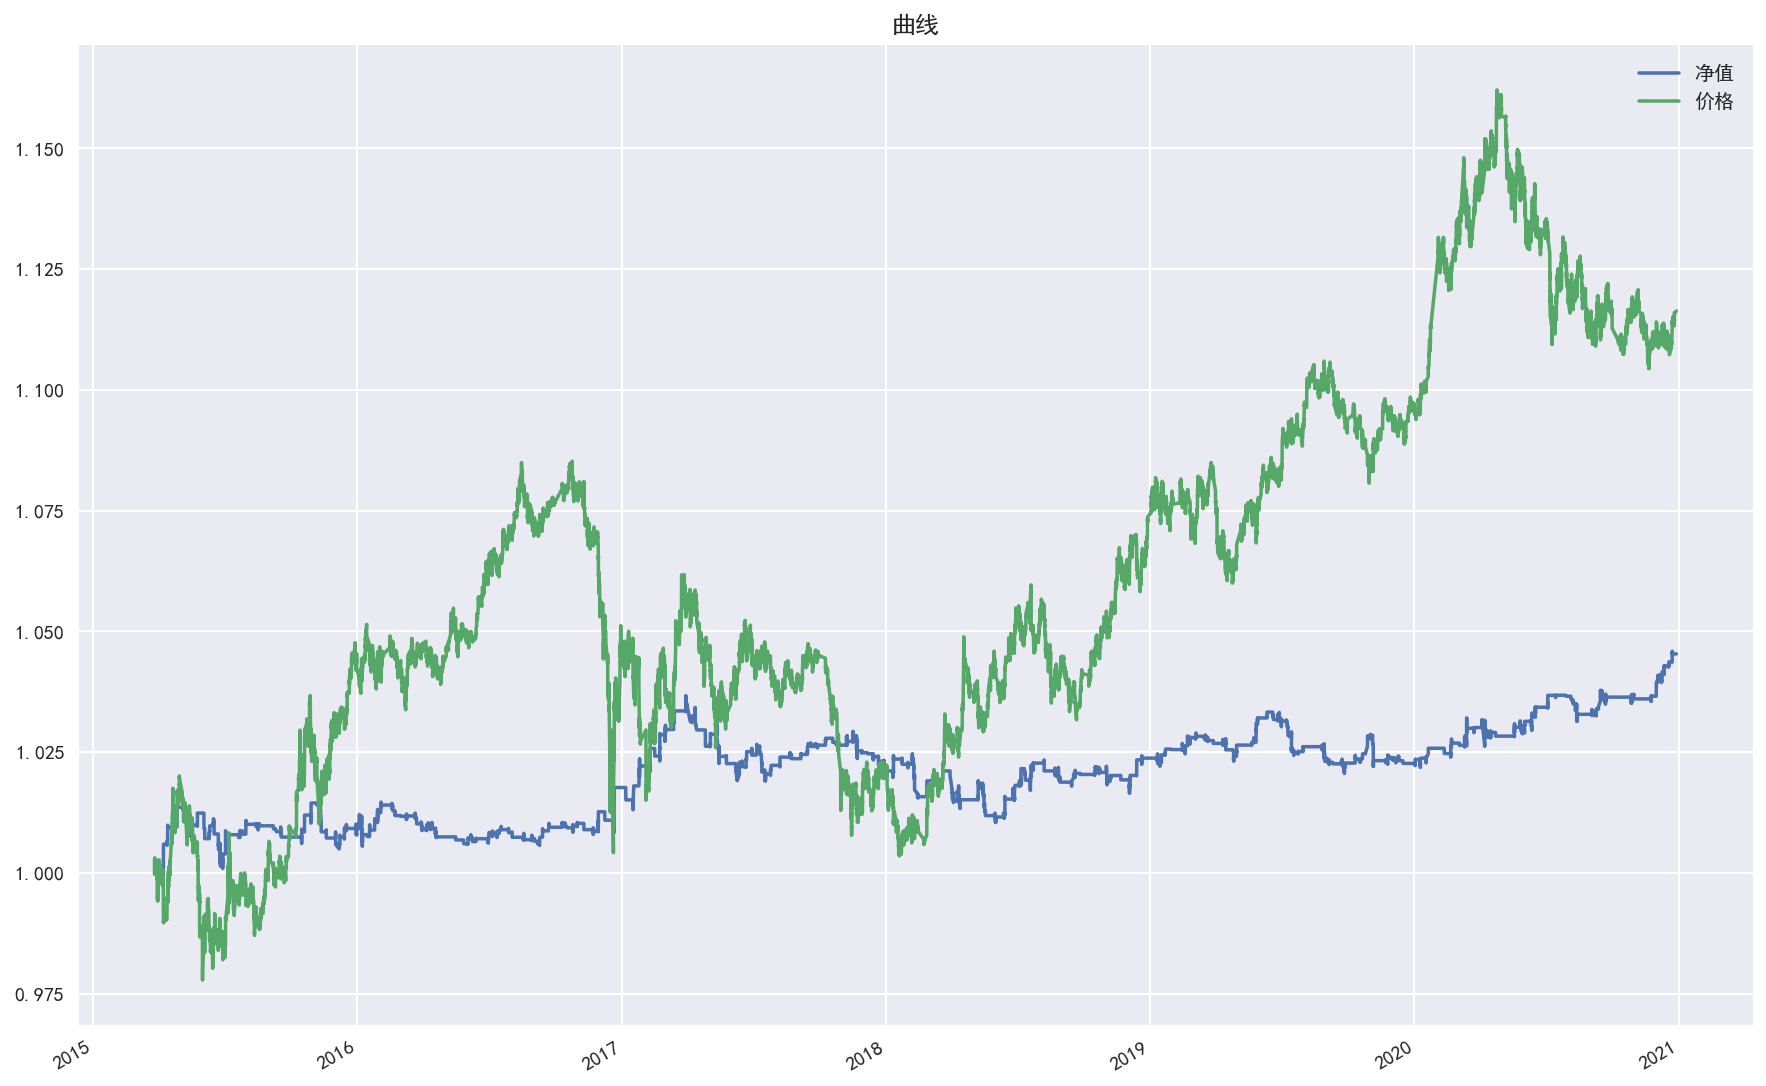

In [30]:
new = back_test(input_position*1, input_price,4*4.5)
new.show_result()
new.result_plot()